In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import random
import pickle
import sys
import numpy as np
from PIL import Image

In [2]:
added_paths = ['../src', '../src/utils']
for added_path in added_paths:
    if added_path not in sys.path:
        sys.path.append(added_path)

from components.data_transformation import DataTransformationConfig, DataTransformer

def load_model():
    with open("../models/best_model.pkl", 'rb') as f:
        return pickle.load(f)
    
class segmentator:
    def __init__(self):
       self.pipeline = None

    def process(self, image):
        new_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        new_image[0,:,:] = 0
        new_image[:,0,:] = 0
        new_image[-1,:,:] = 0
        new_image[:,-1,:] = 0
        return new_image, {'area': 0, 'perimeter': 0, 'eccentricity': 0, 'Equivalent Diameter': 0} 
    
    def process2(self, image):
        image[0,:,:] = 0
        image[:,0,:] = 0
        image[-1,:,:] = 0
        image[:,-1,:] = 0
        return image, {'area': 0, 'perimeter': 0, 'eccentricity': 0, 'Equivalent Diameter': 0} 

class model:
    def __init__(self):
        self.model = load_model()
        colors_features = ['has_blue']
        channel_features = ['mean', 'std', 'median', 'mode', 'min', 'max', 'range', 'skewness', 'kurtosis', 'entropy', 'quantile_0.25', 'quantile_0.75', 'iqr']
        histogram_features = ['mean', 'std', 'median', 'mode', 'min', 'max', 'range', 'skewness', 'kurtosis', 'entropy', 'R']
        coocurrence_matrix_features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        with open('../data/features/correlated_features.txt', 'r') as f:
            correlated_features = [t.strip() for t in f.readlines()]

        # Data Transformation
        self.transformation_config = DataTransformationConfig(
            color_features=colors_features,
            channel_features=channel_features,
            histogram_features=histogram_features,
            coocurrence_matrix_features=coocurrence_matrix_features,
            correlated_features=correlated_features,
            drop_correlated_features=True,
            use_augmentation= 0,
            positive_class="pools",
            negative_class="no_pools",
            to_grayscale=self.to_grayscale,
            to_histogram=self.to_histogram,
        )

        self.transformer = DataTransformer(self.transformation_config)

    def to_grayscale(self, images: list):
        grayscale_images = []
        for image in images:
            grayscale_image = np.array(Image.fromarray(image).convert('L'))
            grayscale_images.append(grayscale_image)
        return grayscale_images

    def to_histogram(self, image_gray: np.ndarray, bins: int = 256):
        hist, _ = np.histogram(image_gray, bins=bins, density=True)
        return hist
    
    def predict(self, image):
        features = self.transformer.transform_single_image(image)
        return self.model.predict(features)[0]

In [15]:
def process_image(image, model: model, segmentator: segmentator):
    division_x = 30
    division_y = 40
    m = image.shape[0] // division_x
    n = image.shape[1] // division_y 

    resultant_image = image.copy()
    frame = pd.DataFrame(columns=['label', 'area', 'perimeter', 'eccentricity', 'Equivalent Diameter'])
    label = 0
    for i in range(division_x):
        for j in range(division_y):
            sub_image = image[int(i*m):int((i+1)*m), int(j*n):int((j+1)*n)]
            #sub_image_rgb = cv2.cvtColor(sub_image, cv2.COLOR_BGR2RGB)
            if model.predict(sub_image):
                segmented_sub_image, caracteristicas = segmentator.process(sub_image)
                caracteristicas['label'] = label
                frame.loc[len(frame)] = caracteristicas
                resultant_image[int(i*m):int((i+1)*m), int(j*n):int((j+1)*n)] = segmented_sub_image
                label += 1
            else:
                resultant_image[int(i*m):int((i+1)*m), int(j*n):int((j+1)*n)] = segmentator.process2(sub_image)[0]

    return resultant_image, frame

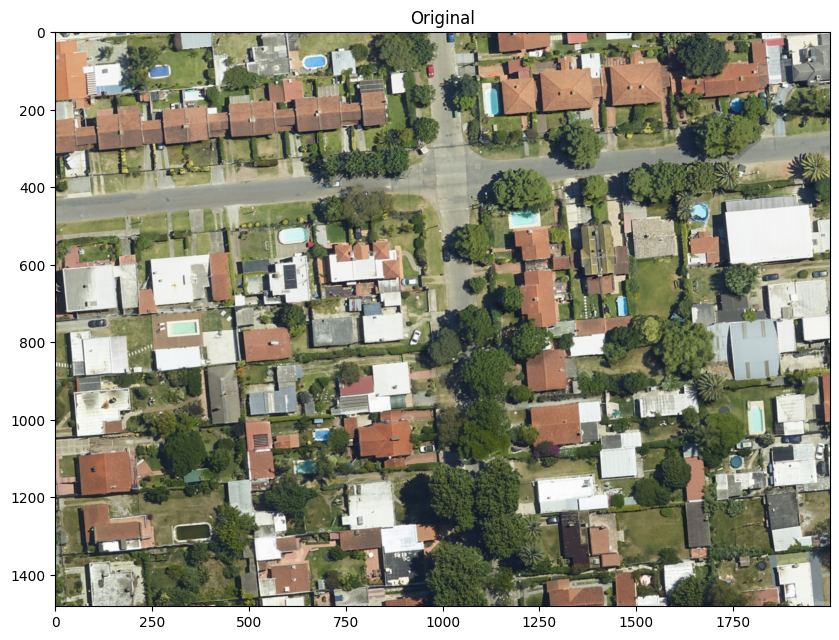

In [16]:
imag = np.array(Image.open(os.path.join('..', 'image_chunk.jpg')))

plt.figure(figsize=(10,10))
plt.imshow(imag)
plt.title('Original')
plt.show()

In [17]:
res = process_image(imag, model(), segmentator())

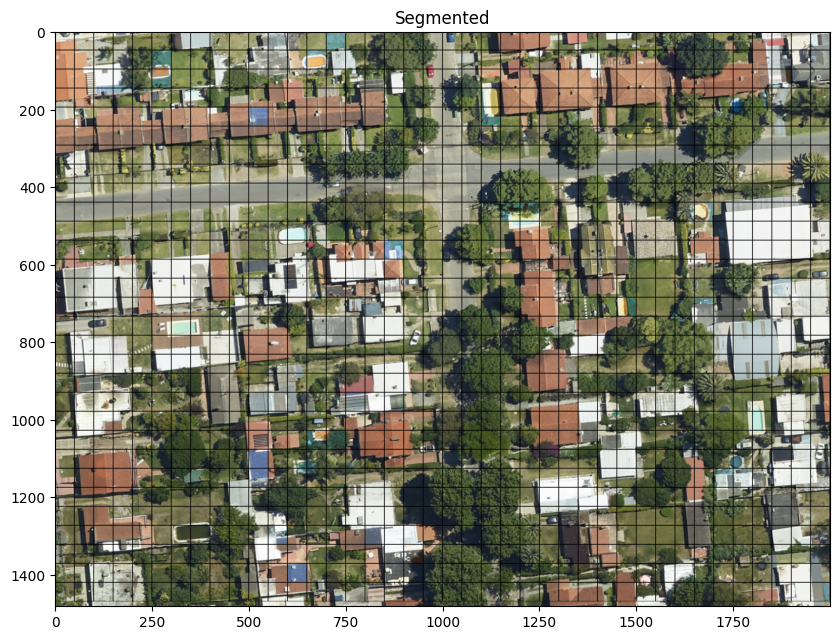

 label  area  perimeter  eccentricity  Equivalent Diameter
     0     0          0             0                    0
     1     0          0             0                    0
     2     0          0             0                    0
     3     0          0             0                    0
     4     0          0             0                    0
     5     0          0             0                    0
     6     0          0             0                    0
     7     0          0             0                    0
     8     0          0             0                    0
     9     0          0             0                    0
    10     0          0             0                    0
    11     0          0             0                    0
    12     0          0             0                    0
    13     0          0             0                    0
    14     0          0             0                    0
    15     0          0             0                   

In [18]:

plt.figure(figsize=(10,10))
plt.imshow(res[0])
plt.title('Segmented')
plt.show()

print(res[1].to_string(index=False))